In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import math
from PIL import Image
%matplotlib inline

In [83]:
def camera_calibation():
    images = glob.glob('./camera_cal/calibration*.jpg')

    object_points = []
    image_points = []

    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        if ret == True:
            image_points.append(corners)
            object_points.append(objp)

            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    img = cv2.imread('./camera_cal/calibration3.jpg')
    img_size = (img.shape[1], img.shape[0])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, img_size, None, None)
    return (mtx, dist)

global calibration
calibration = camera_calibation()

In [84]:
class Line():
    def __init__(self):
        self.recent_amount = 7
        self.weights = [.2,.2,.2,.1,.1,.1,.1]
        self.detected = False
        self.recent_xfitted = []
        self.bestx = None
        self.recent_fits = []
        self.best_fit = None
        self.current_fit = [np.array([False])]
        self.radius_of_curvature = None
        self.line_base_pos = None
        self.allx = None
        self.ally = None

    def preliminary_update(self, line_fit, fitx):
        if line_fit is not None:
            
            if self.should_update(fitx):
                self.detected = True
                self.current_fit = line_fit
                self.allx = fitx
                if self.best_fit is None:
                    self.update()
            else:
                self.detected = False
    
    def should_update(self, new_fitx):
        should_update = True
        
        if  self.bestx is not None:
            
            if new_fitx[719] > self.bestx[719] + 50 or new_fitx[719] < self.bestx[719] - 50:
                should_update = False

        return should_update
    
    def get_radius(self, line):
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)
        curverad = ((1 + (2*line[0]*y_eval + line[1])**2)**1.5) / np.absolute(2*line[0])
        ym_per_pix = 3/170
        xm_per_pix = 3.7/210
        fit_cr = np.polyfit(ploty*ym_per_pix, line*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
        return curverad
    
    def update(self):
        self.detected = True
        self.recent_fits.append(self.current_fit)
        self.recent_fits = self.recent_fits[-self.recent_amount:]
        self.best_fit = np.average(self.recent_fits, axis=0, weights=self.weights[:len(self.recent_fits)]).astype(int)
        self.recent_xfitted.append(self.allx)
        self.recent_xfitted = self.recent_xfitted[-self.recent_amount:]
        self.bestx = np.average(self.recent_xfitted, axis=0, weights=self.weights[:len(self.recent_xfitted)]).astype(int)

In [299]:
def undistort(img, mtx, dist):
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_img

def get_warp_matrix(img):
    src = np.float32([
        [448., 479.],
        [832., 479.],
        [1472., 680.],
        [-192., 680.]
    ])

    dst = np.float32([
        [96., 0.],
        [544., 0.],
        [544., 720.],
        [96., 720.]
    ])

    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M, M_inv

def threshold_image(img):
    kernel = np.ones((14,14),np.uint8)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) 
    
    hls_l = hls[:,:,1]
    th_hls_l = cv2.morphologyEx(hls_l, cv2.MORPH_TOPHAT, kernel)
    hls_l_binary = np.zeros_like(th_hls_l)
    hls_l_binary[(th_hls_l > 20) & (th_hls_l <= 255)] = 1

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB) 
    lab_l = lab[:,:,0]
    th_lab_l = cv2.morphologyEx(lab_l, cv2.MORPH_TOPHAT, kernel)
    lab_l_binary = np.zeros_like(th_lab_l)
    lab_l_binary[(th_lab_l > 20) & (th_lab_l <= 255)] = 1

    lab_b = lab[:,:,2]
    th_lab_b = cv2.morphologyEx(lab_b, cv2.MORPH_TOPHAT, kernel)
    lab_b_binary = np.zeros_like(th_lab_b)
    lab_b_binary[(th_lab_b > 5) & (th_lab_b <= 255)] = 1

    full_mask = np.zeros_like(th_hls_l)
    full_mask[(hls_l_binary == 1) | (lab_l_binary == 1) | (lab_b_binary == 1)] = 1

    kernel = np.ones((6,3),np.uint8)
    erosion = cv2.erode(full_mask,kernel,iterations = 1)

    return erosion

def locate_line(thresholded, lines, lane_side):
    histogram = np.sum(thresholded[thresholded.shape[0]/2:,:], axis=0)
    out_img = np.dstack((thresholded, thresholded, thresholded))*255
    midpoint = np.int(histogram.shape[0]/2)
   
    if lane_side == 'left':
        x_base = np.argmax(histogram[:midpoint])
    else:
        x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(thresholded.shape[0]/nwindows)
    nonzero = thresholded.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    x_current = x_base
    margin = 30
    minpix = 50
    lane_inds = []

    for window in range(nwindows):
        win_y_low = thresholded.shape[0] - (window+1)*window_height
        win_y_high = thresholded.shape[0] - window*window_height
        win_x_low = x_current - margin
        win_x_high = x_current + margin
        cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 2)
        good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
        lane_inds.append(good_inds)
        if len(good_inds) > minpix:
            x_current = np.int(np.mean(nonzerox[good_inds]))
            
    lane_inds = np.concatenate(lane_inds)

    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds]
    
    if x.shape[0] != 0:
        line_fit = np.polyfit(y, x, 2)
        ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
        fitx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
        out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
        radius = get_radius(fitx, ploty)
        lines[lane_side].preliminary_update(line_fit, fitx)
    
    return lines

def line_in_windows(thresholded, line):
    line_fit = fitx = radius = None
    fit = line.current_fit
    out_img = np.dstack((thresholded, thresholded, thresholded))*255
    nonzero = thresholded.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) & (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin))) 
    x = nonzerox[lane_inds]
    y = nonzeroy[lane_inds] 
    
    if x.shape[0] != 0:
        line_fit = np.polyfit(y, x, 2)
        ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
        fitx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
        radius = get_radius(fitx, ploty)
        line.preliminary_update(line_fit, fitx)
    
    return line

def get_radius(line, ploty):
    y_eval = np.max(ploty)
    curverad = ((1 + (2*line[0]*y_eval + line[1])**2)**1.5) / np.absolute(2*line[0])
    ym_per_pix = 3/170
    xm_per_pix = 3.7/210
    fit_cr = np.polyfit(ploty*ym_per_pix, line*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return curverad
    
def get_overlayer(warped, lines):
    if lines is not None:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([lines['left'].bestx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([lines['right'].bestx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        overlayer = cv2.fillPoly(warp_zero, np.int_([pts]), (0,255, 0))
    return overlayer

def get_line_fit(thresholded_image, lines, side):
    
    if lines[side].detected == True:
        lines[side] = line_in_windows(thresholded_image, lines[side])
    
    if lines[side].detected == False:
        lines = locate_line(thresholded_image, lines, side)
        
    return lines[side]


def confirm_angle(left, right):
    ret_value = True

    if left.current_fit[1] > right.current_fit[1] + .6:
        ret_value = False
        
    if left.current_fit[1] < right.current_fit[1] -.6:
        ret_value = False
        
    return ret_value

def confirm_spacing(left, right):
    ret_value = True
    new_space = right.allx[719] - left.allx[719]
    average_space = right.bestx[719] - left.bestx[719]

    if new_space > average_space + 100 or new_space < average_space - 100:
        
        ret_value = False
        
    return ret_value

def confirm_curve(left, right):
    ret_value = True

    if left.current_fit[0] > right.current_fit[0] + .0007:#was .0005
        ret_value = False
        
    if left.current_fit[0] < right.current_fit[0] - .0007:# was .0005
        ret_value = False

    return ret_value

def get_left_right_compliance(target, compare):
    spacing_confirmed = confirm_spacing(target, compare)
    angle_confirmed = confirm_angle(target, compare)
    curve_confirmed = confirm_curve(target, compare)
    return spacing_confirmed and angle_confirmed and curve_confirmed

def get_steer_wheel(curve):
    global steering_wheel
    angle = (4 * (math.pi + math.asin(9/(curve*2)))) * 200.40
    return steering_wheel.rotate(angle)

def overlay_image(original, overlayer, lines):
    global steering_wheel
    overlayed = cv2.addWeighted(original, 1, overlayer, 0.3, 0)

    ploty = np.linspace(0, 719, num=720)
    y_eval = np.max(ploty)
    img = np.zeros_like(original)

    ym_per_pix = 3/170
    xm_per_pix = 3.7/210
    leftx = lines['left'].bestx
    rightx = lines['right'].bestx

    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    road_curve = left_curverad + right_curverad / 2
    road_curve = round(road_curve, 2)
    curve_string = "{:,}".format(road_curve)

    if road_curve > 3000:
        curve_string = 'Straight'
    else:
        curve_string = str(curve_string) + 'm'

    center_of_lines = (rightx[len(rightx)-1] + leftx[len(leftx)-1]) / 2
    distance_from_center = center_of_lines - img.shape[1] / 4
    distance_from_center = distance_from_center * xm_per_pix
    distance_from_center = round(distance_from_center, 2)
    center_offset = "{:,}".format(abs(distance_from_center))

    if distance_from_center > 0:
        center_offset = str(center_offset) + 'm left'
    else:
        center_offset = str(center_offset) + 'm right'

    font = cv2.FONT_HERSHEY_SIMPLEX
    image = cv2.putText(overlayed,'Road Curve: ' + curve_string,(10,50), font, 1.4,(255,255,255),2)
    image = cv2.putText(image, 'Off Center: ' + center_offset,(10,100), font, 1.4,(255,255,255),2)

    if ((left_fit_cr[0] + right_fit_cr[0]) / 2) > 0:
        road_curve = -1 * road_curve
    
    background = Image.fromarray(image).convert("RGBA")
    background.paste(get_steer_wheel(road_curve), (540, 150), get_steer_wheel(road_curve))
    image = np.array(background)
    image = image[:,:,:3]
    
    return image

def pipeline(img):
    global lines, calibration
    
    undistorted_img = undistort(img, calibration[0], calibration[1])
    size_for_warp = (int(undistorted_img.shape[1]/2), undistorted_img.shape[0])
    M, M_inv = get_warp_matrix(undistorted_img)
    warped = cv2.warpPerspective(undistorted_img, M, size_for_warp, flags=cv2.INTER_LINEAR)
    
    thresholded_image = threshold_image(warped)

    left = get_line_fit(thresholded_image, lines, 'left')
    right = get_line_fit(thresholded_image, lines, 'right')
    
    if get_left_right_compliance(left, right) and left.detected:
        left.update()

    if get_left_right_compliance(right, left) and right.detected:  
        right.update()

    overlayer = get_overlayer(warped, lines)
    size_for_unwarp = (int(undistorted_img.shape[1]), undistorted_img.shape[0])
    unwarped = cv2.warpPerspective(overlayer, M_inv, size_for_unwarp, flags=cv2.INTER_LINEAR)
    return overlay_image(undistorted_img, unwarped, lines)


In [300]:
def reset_lines():
    left_line = Line()
    right_line = Line()

    global lines
    lines = {
        'left': left_line, 
        'right': right_line
    }
    
    global steering_wheel
    steering_wheel = Image.open('output_images/steering_wheel.png').convert("RGBA")
    steering_wheel= steering_wheel.resize((200,200),Image.ANTIALIAS)

In [301]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

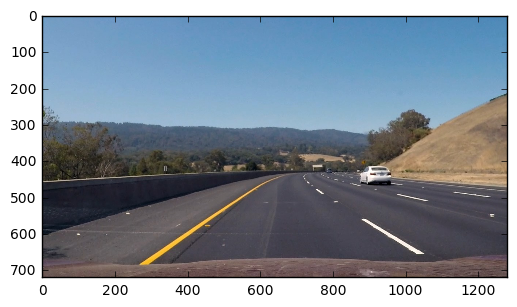

In [302]:
img = mpimg.imread('./test_images/test3.jpg')
pipeline(img)
plt.imshow(img)
plt.show()

In [303]:
reset_lines()
first_output = 'first.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(first_output, audio=False)

[MoviePy] >>>> Building video first.mp4
[MoviePy] Writing video first.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<03:00,  6.98it/s]

  0%|          | 2/1261 [00:00<02:58,  7.03it/s]

  0%|          | 3/1261 [00:00<02:53,  7.25it/s]

  0%|          | 4/1261 [00:00<02:49,  7.39it/s]

  0%|          | 5/1261 [00:00<02:50,  7.36it/s]

  0%|          | 6/1261 [00:00<02:57,  7.05it/s]

  1%|          | 7/1261 [00:00<02:54,  7.17it/s]

  1%|          | 8/1261 [00:01<02:52,  7.28it/s]

  1%|          | 9/1261 [00:01<02:48,  7.42it/s]

  1%|          | 10/1261 [00:01<02:47,  7.49it/s]

  1%|          | 11/1261 [00:01<02:51,  7.30it/s]

  1%|          | 12/1261 [00:01<02:56,  7.08it/s]

  1%|          | 13/1261 [00:01<02:55,  7.13it/s]

  1%|          | 14/1261 [00:01<02:51,  7.29it/s]

  1%|          | 15/1261 [00:02<02:48,  7.40it/s]

  1%|▏         | 16/1261 [00:02<02:48,  7.40it/s]

  1%|▏         | 17/1261 [00:02<02:50,  7.28it/s]

  1%|▏         | 18/1261 [00:02<02:53,  7.15it/s]

  2%|▏         | 19/1261 [00:02<02:49,  7.34it/

[MoviePy] Done.
[MoviePy] >>>> Video ready: first.mp4 



In [304]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(first_output))

In [9]:
reset_lines()
challenge_output = 'challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge.mp4
[MoviePy] Writing video challenge.mp4


100%|██████████| 485/485 [01:05<00:00,  7.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge.mp4 



In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [11]:
reset_lines()
harder_challenge_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
white_clip.write_videofile(harder_challenge_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [02:54<00:00,  6.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 



In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))